In [334]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ngl
from sklearn.metrics.pairwise import haversine_distances
import zipfile
import urllib
import re
from itertools import takewhile
import scipy.signal as sig
import numpy.fft as fft

In [318]:
import requests
import xml.etree.ElementTree as ET
from io import StringIO
import datetime
class irisRequests:
    stations_base_url = "http://service.iris.edu/fdsnws/station/1/query?"
    events_base_url = "http://service.iris.edu/fdsnws/event/1/query?"
    data_base_url = "http://service.iris.edu/fdsnws/dataselect/1/query?"
    query_formats = ["xml", "text","geocsv"]
    events_magnitude_types = ["ML", "Ms", "mb", "Mw","all","preferred"]
    
    
    # GENERIC METHODS

    @staticmethod
    def format_time(start, end):
        time_format = "%Y-%m-%dT%H:%M:%S"
        return {"start" : start.strftime(time_format), "end" : end.strftime(time_format)}
    

    @staticmethod
    def format_box(minlat, maxlat, minlon, maxlon):
        return {"minlat" : minlat, "maxlat" : maxlat, "minlon" : minlon, "maxlon" : maxlon}
    
    @staticmethod
    def format_radial(lat, lon, maxradius, minradius=0, mindepth=None, maxdepth=None):
        format = {"latitude" : lat, "longitude" : lon, "maxradius" : maxradius, "minradius" : minradius}
        if(mindepth is not None):
            format['mindepth'] = mindepth
        if(maxdepth is not None):
            format['maaxdepth'] = maxdepth
        return format
    
    @staticmethod
    def format_magnitude(minmag=None, maxmag=None, magtype= None):
        format = {}
        if(minmag is not None):
            format["minmag"] = minmag
        if(maxmag is not None):
            format["maxmag"] = maxmag
        if(magtype is None):
            format["magnitudetype"] = "preferred"
        return format
    
    @staticmethod
    def format_url(base_url, formats):
        query_str = base_url 
        for format in formats:
            for key, val in format.items():
                query_str += str(key) + "=" +str(val) + "&"
        return query_str
    
    # STATIONS
    @staticmethod
    def process_stations_url(url):
        response = requests.get(url)
        df = pd.read_csv(StringIO(response.content.decode()), comment="#", sep="|")
        if('Latitude' in df.columns):
            df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
        if('Longitude' in df.columns):
            df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
        if('Elevation' in df.columns):
            df['Elevation'] = pd.to_numeric(df['Elevation'], errors='coerce')
        df.dropna(inplace=True)
        df['StartTime'] = pd.to_datetime(df['StartTime'], errors='coerce')
        df['EndTime'] = pd.to_datetime(df['EndTime'], errors='coerce')
        return df
    
    @staticmethod
    def retrieve_all_stations():
        return irisRequests.process_stations_url( irisRequests.stations_base_url + "&format=geocsv")    
    @staticmethod
    def retrieve_networks():
        return irisRequests.process_stations_url( irisRequests.stations_base_url +  "level=network&format=geocsv")  
    @staticmethod
    def retrieve_stations(network):
        return irisRequests.process_stations_url( irisRequests.stations_base_url + "level=station&network=" + network + "&format=geocsv")
    @staticmethod
    def retrieve_channels(network, station):
        return irisRequests.process_stations_url( irisRequests.stations_base_url + "level=channel&network=" + network + "&station=" + station + "&format=geocsv")
    @staticmethod
    def url_stations_box(minlat, maxlat, minlon, maxlon, start_time=None, end_time=None, format="geocsv" ):
        if(start_time != None and end_time != None):
            time_f = irisRequests.format_time(start_time, end_time)
        else:
            time_f = None
        box_f = irisRequests.format_box(minlat, maxlat, minlon, maxlon)
        formats = []
        if(time_f != None):
            formats.append(time_f)
        formats.append(box_f)
        url = irisRequests.format_url(irisRequests.stations_base_url, formats)+ "format=" + format
        return url
    @staticmethod
    def url_stations_radial(lat, lon, maxradius, minradius=0, start_time=None, end_time=None, format="geocsv" ):
        if(start_time != None and end_time != None):
            time_f = irisRequests.format_time(start_time, end_time)
        else:
            time_f = None
        radial_f = irisRequests.format_radial(lat, lon, maxradius, minradius)
        formats = []
        if(time_f != None):
            formats.append(time_f)
        formats.append(radial_f)
        url = irisRequests.format_url(irisRequests.stations_base_url, formats) + "format=" + format
        return url
    
    @staticmethod
    def url_data(network, station,start, end, channel=None, quality="B", repo="primary"):
        data_f = {"network" : network,
                    "station" : station,
                    "quality" : quality,
                    "repo" : repo}
        if(channel is not None):
            data_f["channel"] = channel
        time_f = irisRequests.format_time(start, end)
        format = "geocsv"
        if(channel is None):
            format += ".zip"
        return irisRequests.format_url(irisRequests.data_base_url, [data_f, time_f]) + "format=" + format

    @staticmethod
    def _process_data_file(file):
        numerical_fields  = ["sample_rate_hz", "latitude_deg", "longitude_deg",
                              "elevation_m", "depth_m", "azimuth_deg", "dip_deg", 
                              "scale_factor", "scale_frequency_hz"]
        header = {}
        for line in file.readlines():
            line = line.decode()
            if(line.startswith('#')):
                fields = re.split(r"\s+", line.strip())[1:]
                field_name, field_val = fields[0], fields[1]
                field_name = field_name[:-1]
                if(field_name in numerical_fields):
                    header[field_name] = float(field_val)          
        file.seek(0)
        df = pd.read_csv(file, comment="#", sep=",", parse_dates=["Time"])
        df.rename({" Sample" : "Sample"}, axis=1, inplace=True)
        return df, header
    @staticmethod
    def process_data_url(url):
        
        filehandle,_ = urllib.request.urlretrieve(url )
        if(".zip" in url):

            zip_file_object = zipfile.ZipFile(filehandle, 'r')
            dataframes = {}
            for nl in zip_file_object.namelist():
                channel = re.findall(r"\.CH[A-Za-z]\.", nl )[0][1:-1]
                file = zip_file_object.open(nl)
                df, header = irisRequests._process_data_file(file)
                dataframes[channel] = (df,header) 
            return dataframes

    # EVENTS

    @staticmethod
    def get_events_catalogs():
        catalog_list = "http://service.iris.edu/fdsnws/event/1/catalogs"
        response = requests.get(catalog_list)
        names =  ET.parse(StringIO(response.content.decode('ascii'))).findall("Catalog")
        return [name.text.strip() for name in names]
    

    @staticmethod
    def url_events(formats):
        return irisRequests.format_url(irisRequests.events_base_url, formats)
        
    
    @staticmethod
    def url_events_box(start_time, end_time, minlat, maxlat, minlon, maxlon, minmag=None, maxmag=None, magtype=None,format="geocsv"):
        time_f = irisRequests.format_time(start_time, end_time)
        box_f = irisRequests.format_box(minlat, maxlat, minlon, maxlon)
        mag_f = irisRequests.format_magnitude(minmag,maxmag,  magtype)
        s = irisRequests.url_events([time_f, box_f, mag_f]) + "format=" + format
        return s

In [319]:
dfs = irisRequests.process_data_url(irisRequests.url_data("3F", "INS2", datetime.datetime(2016, 9, 30, 0, 0, 0), datetime.datetime(2016, 9, 30, 1, 0, 0)))

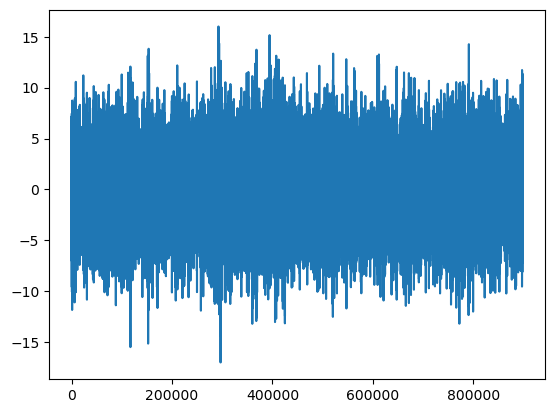

In [350]:
s = dfs['CHN'][0].Sample.values
f = fft.fftfreq(len(s), 1/250)
s_f = fft.fft(s)
s_f[np.abs(f) < 1] = 0
s_f[np.abs(f) > 5] = 0
plt.plot(fft.ifft(s_f).real[1000:-1000])

In [176]:
my_stations = irisRequests.process_stations_url(irisRequests.url_stations_radial(40, 14, 3.0))

In [179]:
my_stations[my_stations.EndTime < datetime.datetime(2023, 9, 1)]

,Network,Station,Latitude,Longitude,Elevation,SiteName,StartTime,EndTime
0,3F,INS1,40.305790,15.988603,802.0,Montemurro cemetery,2016-09-23 09:16:28.430000,2019-03-23 23:59:59.999900
1,3F,INS2,40.342090,15.951559,1043.0,Viggiano,2016-09-23 14:59:37.504000,2017-03-22 10:03:46.385000
2,3F,INS2,40.342090,15.951559,1043.0,Viggiano,2017-03-22 11:17:09.745000,2019-03-23 23:59:59.999900
3,3F,INS3,40.328033,16.034446,880.0,Armento,2016-08-26 12:03:13.071600,2017-03-22 14:52:43.402000
4,3F,INS3,40.328033,16.034446,880.0,Armento,2017-03-22 15:22:19.589000,2019-03-23 23:59:59.999900
...,...,...,...,...,...,...,...,...
176,ZV,UAF5,38.794340,15.217150,881.0,UAF5,2022-05-09 08:00:00.000000,2022-05-15 00:00:00.000000
177,ZV,UAF6,38.793670,15.216790,913.0,UAF6,2022-05-09 11:00:00.000000,2022-05-15 00:00:00.000000
178,ZV,UAF7,38.793280,15.215380,922.0,UAF7,2022-05-09 11:00:00.000000,2022-05-15 00:00:00.000000
179,ZV,UAF8,38.792670,15.213970,958.0,UAF8,2022-05-09 12:00:00.000000,2022-05-15 00:00:00.000000


In [167]:
for _, row in my_stations.iterrows():
    net, stat = row.Network, row.Station
    print(irisRequests.retrieve_channels(net, stat))

  Network Station  Location Channel   Latitude  Longitude  Elevation  Depth  \
1      YD    CAVE       1.0     BHE  40.449001    15.0531      218.0    0.0   
2      YD    CAVE       1.0     BHE  40.449001    15.0531      218.0    0.0   
3      YD    CAVE       1.0     BHN  40.449001    15.0531      218.0    0.0   
4      YD    CAVE       1.0     BHN  40.449001    15.0531      218.0    0.0   
5      YD    CAVE       1.0     BHZ  40.449001    15.0531      218.0    0.0   
6      YD    CAVE       1.0     BHZ  40.449001    15.0531      218.0    0.0   
7      YD    CAVE       1.0     HHE  40.449001    15.0531      218.0    0.0   
8      YD    CAVE       1.0     HHN  40.449001    15.0531      218.0    0.0   
9      YD    CAVE       1.0     HHZ  40.449001    15.0531      218.0    0.0   

   Azimuth   Dip                    SensorDescription        Scale  ScaleFreq  \
1     90.0   0.0   Guralp CMG3T/Reftek 130 Datalogger  946571000.0        0.8   
2     90.0   0.0  Guralp CMG40T/Reftek 130 Data

# GPS

In [82]:
rootpath = "csv_24/"

In [83]:
station_list = ngl.ngl_process_list(ngl.ngl_24h_2w)

In [84]:
names = ngl.get_all_stations_within_radius(station_list, 40, 14, 200)

In [86]:
start_date = np.datetime64("2018-01-01")
dataset = {}
init_pos = {}
for name in names:
    df, status = ngl.ngl_final_24h(rootpath, name, force_download=False)
    df = df[df.date >= start_date].reset_index(drop=True)[['date', 'lat', 'lon']]
    if(len(df) > 0):
        df['lon'] = df['lon'] % 180
        df['tindex'] = (df['date'] - start_date).astype('timedelta64[D]').astype('int')
        init_pos[name] = df[['lat','lon']].values[0]
        df['lon'] = (df['lon'] - df['lon'].values[0])*1e6
        df['lat'] = (df['lat'] - df['lat'].values[0])*1e6
        dataset[name] = df

KeyboardInterrupt: 

In [ ]:
indexed_data = {}
for name, data in dataset.items():
    for _, row in data.iterrows():
        if(not row.tindex in indexed_data):
            indexed_data[row.tindex] = []
        indexed_data[row.tindex].append((init_pos[name][0], init_pos[name][1], row.lat, row.lon))

In [ ]:
for key, data in indexed_data.items():
    indexed_data[key] = np.array(data)

In [ ]:
time_indices = np.array(list(indexed_data.keys()))

In [ ]:
class RState(nn.Module):
    def __init__(self, initial_values) -> None:
        super().__init__()
        self.displ = nn.Sequential(
            nn.Linear(3, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2)
        )

        #self.background = nn.Sequential(
        #    nn.Linear(3, 100),
        #    nn.Tanh(),
        #    nn.Linear(100,50),
        #    nn.Tanh(),
        #    nn.Linear(50, 10),
        #    nn.Tanh(),
        #    nn.Linear(10, 2)
        #)

        self.rstate = nn.Parameter(torch.Tensor(initial_values), requires_grad=True)

    def forward(self, x,y, t):
        inputs = torch.cat([x,y,t], axis=1)
        u_out = self.displ(inputs)
        #f_out = self.background(inputs)
        return u_out #, f_out


In [ ]:
def pinn(x,y, t, net):
    u = net(x,y,t)
    u1_t = torch.autograd.grad(
            u[:,0], t, 
            grad_outputs=torch.ones_like(u[:,0]),
            retain_graph=True,
            create_graph=True
        )[0]
    u2_t = torch.autograd.grad(
            u[:,1], t, 
            grad_outputs=torch.ones_like(u[:,1]),
            retain_graph=True,
            create_graph=True
        )[0]
    u1_x = torch.autograd.grad(
            u[:,0], x, 
            grad_outputs=torch.ones_like(u[:,0]),
            retain_graph=True,
            create_graph=True
        )[0]
    u2_x = torch.autograd.grad(
            u[:,1], x, 
            grad_outputs=torch.ones_like(u[:,1]),
            retain_graph=True,
            create_graph=True
        )[0]
    u1_y = torch.autograd.grad(
            u[:,0], y, 
            grad_outputs=torch.ones_like(u[:,0]),
            retain_graph=True,
            create_graph=True
        )[0]
    u2_y = torch.autograd.grad(
            u[:,1], y, 
            grad_outputs=torch.ones_like(u[:,1]),
            retain_graph=True,
            create_graph=True
        )[0]
    pde1 = u1_t-net.rstate[0]*u[:,0]-net.rstate[1]*u1_x-net.rstate[2]*u1_y
    pde2 = u2_t-net.rstate[3]*u[:,1]-net.rstate[4]*u2_x-net.rstate[5]*u2_y
    ##pde = u_tt-net.rstate[0]*u_t - net.rstate[1]*u
    #pde = net.rstate[0]*u
    #pde += net.rstate[2]*u_x
    #pde += net.rstate[3]*u_y
    #pde += net.rstate[4]*u_xx
    #pde += net.rstate[5]*u_xy
    #pde += net.rstate[6]*u_yy
    return pde1, pde2

In [ ]:
net = RState(np.random.rand(6))
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
temp_pos = np.array(list(init_pos.values()))
min_lat, max_lat, min_lon, max_lon = int(temp_pos[:, 0].min()), int(temp_pos[:,0].max()), int(temp_pos[:, 1].min()), int(temp_pos[:,1].max())

In [ ]:
iterations = 200
np.random.seed(0)
w_pde = 0.5
loss_hist = []
for epoch in range(iterations):
    print(epoch)
    optimizer.zero_grad()
    inputs_x = []
    inputs_y = []
    inputs_t = []
    outputs_u = []
    for time_index in np.random.permutation(time_indices):
        x_bc, y_bc, u_bc = torch.Tensor(indexed_data[time_index][:, 0]), torch.Tensor(indexed_data[time_index][:, 1]), torch.Tensor(indexed_data[time_index][:, 2:])
        t_bc = torch.ones(len(x_bc))*time_index/365
        inputs_x.append((x_bc-min_lat)/(max_lat-min_lat))
        inputs_y.append((y_bc-min_lon)/(max_lon-min_lon))
        inputs_t.append(t_bc)
        outputs_u.append(u_bc)
    inputs_x = torch.concat(inputs_x, axis=0)
    inputs_y = torch.concat(inputs_y, axis=0)
    inputs_t = torch.concat(inputs_t, axis=0)
    outputs_u = torch.concat(outputs_u, axis=0)
    u_bc_out = net(inputs_x[:,None],inputs_y[:,None], inputs_t[:,None])
    loss = torch.mean((u_bc_out-outputs_u)**2)
        
    lat_collocation = np.random.uniform(low=0, high=1, size=(500,1))
    lon_collocation = np.random.uniform(low=0, high=1, size=(500,1))
    t_collocation = np.random.uniform(low=time_indices.min(), high=time_indices.max(), size=(500,1))/365

    pt_lat_collocation = Variable(torch.Tensor(lat_collocation), requires_grad=True)
    pt_lon_collocation = Variable(torch.Tensor(lon_collocation), requires_grad=True)
    pt_t_collocation = Variable(torch.Tensor(t_collocation), requires_grad=True)
    pde1,pde2 = pinn(pt_lat_collocation, pt_lon_collocation, pt_t_collocation, net)
    loss =  (1-w_pde)*loss + w_pde*0.5*torch.mean(pde1**2)+w_pde*0.5*torch.mean(pde2**2)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    if(epoch % 10 == 0):
        plt.plot(loss_hist)
        plt.yscale('log')
        plt.show()
    print(net.rstate)

In [ ]:
timetime, latlat, lonlon = np.meshgrid(np.linspace(0, 3,100), np.linspace(0, 1), np.linspace(0, 1), indexing='ij')

In [ ]:
timetime = timetime.flatten()
latlat = latlat.flatten()
lonlon = lonlon.flatten()

In [ ]:
with torch.no_grad():
    uu = net(torch.Tensor(latlat)[:,None],torch.Tensor(lonlon)[:,None],  torch.Tensor(timetime)[:,None])
    uu = uu.reshape((100,50,50,2))
#plt.plot(uu.mean(axis=(1,2))[:,0])
#plt.show()
#plt.plot(uu.mean(axis=(1,2))[:,1])
for _ in range(uu.shape[0]):
    plt.contourf(torch.norm(uu[_,:,:,:], dim=-1),levels=100, cmap='seismic')
    plt.colorbar()
    plt.show()

In [ ]:
for idx, d in indexed_data.items():
    plt.scatter(idx/365, d[:,2].mean(), color='black')